In [1]:
'''
处理movielens数据
新增了对某个item社会共识的计算
'''

import pandas as pd 
import numpy as np
from tqdm import tqdm
from scipy.sparse import coo_matrix,csr_matrix
import scipy.sparse as sp
import random
import pickle
import math

RATING_FILE_NAME = dict({'movie': 'ratings.txt', # Following MKR
                         'Amazon_book': 'BX-Book-Ratings.csv', #Following LightGCN
                         'music': 'user_artists.dat',
                         'news': 'ratings.txt'})
SEP = dict({'movie': '::', 'Amazon_book': ';', 'music': '\t', 'news': '\t'})
HitRateThreshold=dict({'movie':0.2,'book':0,'music':0})
User_Item_SampleNum=dict({'movie':3000,'book':0,'music':0})
Item_User_SampleNum=dict({'movie':5000,'book':0,'music':0})

In [ ]:
def data_Template():
    '''
    Amazon book, 这是一个构造数据集所有流程的模板, 下面会分函数
    '''
    ## 读取Amazon Book的数据

    train_user_item=dict()
    train_item_user=dict()
    test_user_item=dict()
    test_item_user=dict()

    file_path='./data/book/'
    train_data=file_path+'train.txt'
    test_data=file_path+'test.txt'

    # 先把所有数据读出来
    for line in open(train_data,encoding='utf-8').readlines():
        datas=line.strip().split(' ')
        user_id=int(datas[0])
        if user_id not in train_user_item.keys():
            train_user_item[user_id]=set()
            
        for data in datas[1:]:
            item_id=int(data)
            train_user_item[user_id].add(item_id)

            if item_id not in train_item_user.keys():
                train_item_user[item_id]=set()
            train_item_user[item_id].add(user_id)

    for line in open(test_data,encoding="utf-8").readlines():
        datas=line.strip().split(' ')

        user_id=int(datas[0])
        if user_id not in test_user_item.keys():
            test_user_item[user_id]=set()
            
        for data in datas[1:]:
            item_id=int(data)
            test_user_item[user_id].add(item_id)
            if item_id not in test_item_user.keys():
                test_item_user[item_id]=set()
            test_item_user[item_id].add(user_id)

    # 统计一下有多少用户，多少物品
    item_nums=len(train_item_user.keys())
    user_nums=len(train_user_item.keys())
    print(f"user_num:{user_nums}, item_num:{item_nums}")


    # contruct item hit rate
    item_hitRate=dict()
    for item in train_item_user.keys():
        item_hitRate[item]=len(train_item_user[item])/user_nums


    # 判断是否每个用户都至少有一个交互
    for user in train_user_item.keys(): 
        if len(train_user_item[user])==0:
            print(f"uu:{user}")
    for user in test_user_item.keys(): 
        if len(test_user_item[user])==0:
            print(f"uu:{user}") # 发现测试集里有用户没访问item，要特殊处理 [13647,41589,50736,52234]

    # 判断是否每个物品都被至少一个用户访问过: √
    for item in train_item_user.keys(): 
        if len(train_item_user[item])==0:
            print(f"ii:{item}")
    for item in test_item_user.keys(): 
        if len(test_item_user[item])==0:
            print(f"ii:{item}")

    # 统计一下训练集有多少交互
    train_interaction_num=0
    for user in train_user_item.keys():
        train_interaction_num+=len(train_user_item[user])
    print(train_interaction_num)
    print(train_interaction_num/2984108) # 看看是按照什么比例划分数据集


    ## 使用训练集构造邻接矩阵
    row=[]
    col=[]
    data=[]
    for user_id in train_user_item.keys():
        for item_id in train_user_item[user_id]:
            row.append(user_id)
            col.append(item_id+len(train_user_item))
            data.append(1)
    for item_id in train_item_user.keys(): 
        for user_id in train_item_user[item_id]:
            row.append(item_id+len(train_user_item))
            col.append(user_id)
            data.append(1)

    csr_adj_matrix=csr_matrix((data,(row,col)))


    ## 构造训练数据
    # # 和LightGCN稍有差别，差别在于对user的采样方式
    # item_set=set(range(user_nums))
    # train_data=[]
    # for user in train_user_item.keys():
    #     for p_item in range(len(train_user_item[user])):
    #         n_item=np.random.choice(list(item_set-train_user_item[user]))
    #         row_data=[user,p_item,n_item]
    #         train_data.append(row_data)
    # 和LightGCN完全一样
    train_data=[]
    users = np.random.randint(0, user_nums, train_interaction_num)
    for user in users:
        posForUser = list(train_user_item[user]) # 得到这个用户的所有正样本list
        if len(posForUser) == 0: # 如果这个用户没有正样本，跳过
            continue
        posindex = np.random.randint(0, len(posForUser)) # 从这个用户的所有正样本随机抽一个
        p_item = posForUser[posindex]
        while True:
            n_item = np.random.randint(0, item_nums) # 从所有item中随机抽一个
            if n_item in posForUser: # 如果抽中的在正样本集中，继续抽，知道抽出一个负样本
                continue
            else:
                break
        train_data.append([user, p_item, n_item]) # 添加到训练集

    return train_user_item,test_user_item,train_item_user,test_item_user,item_hitRate,csr_adj_matrix,train_data

# # 调用方法
# train_user_item,test_user_item,train_item_user,test_item_user,item_hitRate,csr_adj_matrix,train_data=data_Template()

# ## 保存以上数据
# DATASET='book'
# sp.save_npz('./data/'+DATASET+'/csr_'+DATASET+'_matrix.npz',csr_adj_matrix)
# np.save("./data/"+DATASET+"/train_user_item.npy",train_user_item)
# np.save("./data/"+DATASET+"/test_user_item.npy",test_user_item)
# np.save("./data/"+DATASET+"/item_hitRate.npy",item_hitRate)


# # 测一下生成的邻接矩阵和原训练集数据是否一致
# print(csr_adj_matrix.sum(axis=1)[15])
# print(len(train_user_item[15]))
# print(csr_adj_matrix.sum(axis=1)[len(train_user_item)+256])
# print(len(train_item_user[256]))


# # 检查一下训练数据是不是正确的
# print(train_data[9854])
# print(432 in train_user_item[12856])
# print(43997 in train_user_item[12856])
# print(len(train_data))

In [4]:
def dict_construct_book():
    
    ## 读取Amazon Book的数据
    train_user_item=dict()
    train_item_user=dict()
    test_user_item=dict()
    test_item_user=dict()

    file_path='./data/book/'
    train_data=file_path+'train.txt'
    test_data=file_path+'test.txt'

    # 先把所有数据读出来
    for line in open(train_data,encoding='utf-8').readlines():
        datas=line.strip().split(' ')
        user_id=int(datas[0])
        if user_id not in train_user_item.keys():
            train_user_item[user_id]=set()
            
        for data in datas[1:]:
            item_id=int(data)
            train_user_item[user_id].add(item_id)

            if item_id not in train_item_user.keys():
                train_item_user[item_id]=set()
            train_item_user[item_id].add(user_id)

    for line in open(test_data,encoding="utf-8").readlines():
        datas=line.strip().split(' ')

        user_id=int(datas[0])
        if user_id not in test_user_item.keys():
            test_user_item[user_id]=set()
            
        for data in datas[1:]:
            item_id=int(data)
            test_user_item[user_id].add(item_id)
            if item_id not in test_item_user.keys():
                test_item_user[item_id]=set()
            test_item_user[item_id].add(user_id)

    # 统计一下有多少用户，多少物品
    item_num=len(train_item_user.keys())
    user_num=len(train_user_item.keys())
    print(f"user_num:{user_num}, item_num:{item_num}")

    # 判断是否每个用户都至少有一个交互
    for user in train_user_item.keys(): 
        if len(train_user_item[user])==0:
            print(f"uu:{user}")
    for user in test_user_item.keys(): 
        if len(test_user_item[user])==0:
            print(f"uu:{user}") # 发现测试集里有用户没访问item，要特殊处理 [13647,41589,50736,52234]

    # 判断是否每个物品都被至少一个用户访问过: √
    for item in train_item_user.keys(): 
        if len(train_item_user[item])==0:
            print(f"ii:{item}")
    for item in test_item_user.keys(): 
        if len(test_item_user[item])==0:
            print(f"ii:{item}")

    return train_user_item,train_item_user,test_user_item,test_item_user,user_num,item_num


def dict_construct_movie(split_rate=0.8,positive_replace=False):
    '''
        movielens-1M
        采样的时候按照从item的层面(实验说明这样有效)进行采样, 因为item的数量少, 所以能够保证训练集中一个物品至少被一个用户访问,一个用户至少访问一个物品
        这样做, 对于某些只访问过一个item的用户, 它的测试集gt是空的, 所以测试集要做处理
    '''
    
    item_index_old2new = dict()
    item_index_new2old = dict()
    user_index_old2new = dict()
    user_index_new2old = dict()
    user_item = dict()
    item_user=dict()
    
    # 读取数据并按照从0开始，重标号

    file = './data/movie/ratings.dat'
    print('reading ratings file: ' + file + ' ...')
    i = 0
    j = 0
    for line in open(file, encoding='utf-8').readlines():
        line_data=line.strip().split('::')
        user_index = int(line_data[0])
        item_index = int(line_data[1])
        rating = int(line_data[2])

        if user_index not in user_index_old2new:
            user_index_old2new[user_index] = i
            user_index_new2old[i]=user_index
            i += 1
        if item_index not in item_index_old2new:
            item_index_old2new[item_index] = j
            item_index_new2old[j]=item_index
            j+=1

        if rating > 0:
            if user_index_old2new[user_index] not in user_item:
                user_item[user_index_old2new[user_index]]=set()
            user_item[user_index_old2new[user_index]].add(item_index_old2new[item_index])

            if item_index_old2new[item_index] not in item_user:
                item_user[item_index_old2new[item_index]]=set()
            item_user[item_index_old2new[item_index]].add(user_index_old2new[user_index])
        
    # 统计数据集中用户和物品总数
    user_num=len(user_item)
    item_num=len(item_user)
    print("The num of user is %d " % (user_num))
    print("The num of item is %d " % (item_num))
    
    # 将所有交互按照0.8划分训练集和测试集
    train_user_item=dict()
    train_item_user=dict()
    test_user_item=dict()
    test_item_user=dict()


    while True:

        for item in item_user.keys():
            if not positive_replace:    # 这里使用math.ceil取上整，是为了尽量让物品被采样在训练集，对于movielens这种稀疏数据集，一个用户可能只访问过一个物品，那就把这个物品放在训练集
                train_item_user[item]=set(np.random.choice(list(item_user[item]), size=math.ceil(split_rate*len(item_user[item])),replace=False)) #不允许重复采样，保证训练和测试的正样本是8:2，加个set()去重
            else:
                train_item_user[item]=set(np.random.choice(list(item_user[item]), size=math.ceil(split_rate*len(item_user[item])),replace=True))#允许重复采样，正样本可能比0.8小，加个set()去重
            test_item_user[item]=item_user[item]-set(train_item_user[item])

        train_user_set=set()
        for item in train_item_user.keys():
            train_user_set=train_user_set.union(train_item_user[item])
        
        if len(train_user_set)==user_num: # 直到训练集中出现了所有用户，停止循环
            break
    

    # 将train_user_item转为train_item_user,用于构造adjacency graph
    for item in train_item_user.keys():
        for user in train_item_user[item]:
            if user not in train_user_item.keys():
                train_user_item[user]=set()
            train_user_item[user].add(item)
    # 将test_user_item转为test_item_user
    for item in test_item_user.keys():
        for user in test_item_user[item]:
            if user not in test_user_item.keys():
                test_user_item[user]=set()
            test_user_item[user].add(item)

    # 判断是否每个用户都至少有一个交互
    for user in train_user_item.keys(): 
        if len(train_user_item[user])==0:
            print(f"train_user_index_new2old[user]:{user}->{user_index_new2old[user]}")
    for user in test_user_item.keys(): 
        if len(test_user_item[user])==0:
            print(f"test_user_index_new2old[user]:{user}->{user_index_new2old[user]}") # 发现测试集里有用户没访问item，要特殊处理 [13647,41589,50736,52234]

    # 判断是否每个物品都被至少一个用户访问过: √
    for item in train_item_user.keys(): 
        if len(train_item_user[item])==0:
            print(f"train_item_index_new2old[item]:{item}->{item_index_new2old[item]}")
    for item in test_item_user.keys(): 
        if len(test_item_user[item])==0:
            print(f"test_item_index_new2old[item]:{item}->{item_index_new2old[item]}")
            
    return train_user_item,train_item_user,test_user_item,test_item_user,user_num,item_num


# def dict_construct_movie_v2(split_rate=0.8,positive_replace=False):
#     '''
#         采样的时候, 保证训练集中每个用户至少访问一个物品, 每个物品至少访问一个用户，只有这样才停止采样，否则再采一次
#     '''
    
#     item_index_old2new = dict()
#     item_index_new2old = dict()
#     user_index_old2new = dict()
#     user_index_new2old = dict()
#     user_item = dict()
#     item_user=dict()
    
#     # 读取数据并按照从0开始，重标号

#     file = './data/movie/ratings.dat'
#     print('reading ratings file: ' + file + ' ...')
#     i = 0
#     j = 0
#     for line in open(file, encoding='utf-8').readlines():
#         line_data=line.strip().split('::')
#         user_index = int(line_data[0])
#         item_index = int(line_data[1])
#         rating = int(line_data[2])

#         if user_index not in user_index_old2new:
#             user_index_old2new[user_index] = i
#             user_index_new2old[i]=user_index
#             i += 1
#         if item_index not in item_index_old2new:
#             item_index_old2new[item_index] = j
#             item_index_new2old[j]=item_index
#             j+=1

#         if rating > 0:
#             if user_index_old2new[user_index] not in user_item:
#                 user_item[user_index_old2new[user_index]]=set()
#             user_item[user_index_old2new[user_index]].add(item_index_old2new[item_index])

#             if item_index_old2new[item_index] not in item_user:
#                 item_user[item_index_old2new[item_index]]=set()
#             item_user[item_index_old2new[item_index]].add(user_index_old2new[user_index])
        
#     # 统计数据集中用户和物品总数
#     user_num=len(user_item)
#     item_num=len(item_user)
#     print("The num of user is %d " % (user_num))
#     print("The num of item is %d " % (item_num))
    
#     # 将所有交互按照0.8划分训练集和测试集
#     train_user_item=dict()
#     train_item_user=dict()
#     test_user_item=dict()
#     test_item_user=dict()

#     while True:

#         for user in user_item.keys():
#             if not positive_replace:
#                 train_user_item[user]=set(np.random.choice(list(user_item[user]), size=math.ceil(split_rate*len(user_item[user])),replace=False)) #不允许重复采样，保证训练和测试的正样本是8:2，加个set()去重
#             else:
#                 train_user_item[user]=set(np.random.choice(list(user_item[user]), size=math.ceil(split_rate*len(user_item[user])),replace=True))#允许重复采样，正样本可能比0.8小，加个set()去重
#             test_user_item[user]=user_item[user]-set(train_user_item[user])

#         train_item_set=set()
#         for user in train_user_item.keys():
#             train_item_set=train_item_set.union(train_user_item[user])
        
#         if len(train_item_set)==item_num:
#             break
    
#     # 将train_user_item转为train_item_user,用于构造adjacency graph
#     for user in train_user_item.keys():
#         for item in train_user_item[user]:
#             if item not in train_item_user.keys():
#                 train_item_user[item]=set()
#             train_item_user[item].add(user)
#     # 将test_user_item转为test_item_user
#     for user in test_user_item.keys():
#         for item in test_user_item[user]:
#             if item not in test_item_user.keys():
#                 test_item_user[item]=set()
#             test_item_user[item].add(user)

#     # 判断是否每个用户都至少有一个交互
#     for user in train_user_item.keys(): 
#         if len(train_user_item[user])==0:
#             print(f"uu:{user}")
#     for user in test_user_item.keys(): 
#         if len(test_user_item[user])==0:
#             print(f"uu:{user}") # 发现测试集里有用户没访问item，要特殊处理 [13647,41589,50736,52234]

#     # 判断是否每个物品都被至少一个用户访问过: √
#     for item in train_item_user.keys(): 
#         if len(train_item_user[item])==0:
#             print(f"ii:{item}")
#     for item in test_item_user.keys(): 
#         if len(test_item_user[item])==0:
#             print(f"ii:{item}")
#     return train_user_item,train_item_user,test_user_item,test_item_user,user_num,item_num

# def dict_construct_movie_v3(split_rate=0.8,positive_replace=False):
#     '''
#         采样的时候, 保证训练集中每个用户至少访问一个物品, 每个物品至少访问一个用户，只有这样才停止采样，否则再采一次
#         从user的层面采会不会快一点
#     '''
    
#     item_index_old2new = dict()
#     item_index_new2old = dict()
#     user_index_old2new = dict()
#     user_index_new2old = dict()
#     user_item = dict()
#     item_user=dict()
    
#     # 读取数据并按照从0开始，重标号

#     file = './data/movie/ratings.dat'
#     print('reading ratings file: ' + file + ' ...')
#     i = 0
#     j = 0
#     for line in open(file, encoding='utf-8').readlines():
#         line_data=line.strip().split('::')
#         user_index = int(line_data[0])
#         item_index = int(line_data[1])
#         rating = int(line_data[2])

#         if user_index not in user_index_old2new:
#             user_index_old2new[user_index] = i
#             user_index_new2old[i]=user_index
#             i += 1
#         if item_index not in item_index_old2new:
#             item_index_old2new[item_index] = j
#             item_index_new2old[j]=item_index
#             j+=1

#         if rating > 0:
#             if user_index_old2new[user_index] not in user_item:
#                 user_item[user_index_old2new[user_index]]=set()
#             user_item[user_index_old2new[user_index]].add(item_index_old2new[item_index])

#             if item_index_old2new[item_index] not in item_user:
#                 item_user[item_index_old2new[item_index]]=set()
#             item_user[item_index_old2new[item_index]].add(user_index_old2new[user_index])
        
#     # 统计数据集中用户和物品总数
#     user_num=len(user_item)
#     item_num=len(item_user)
#     print("The num of user is %d " % (user_num))
#     print("The num of item is %d " % (item_num))
    
#     # 将所有交互按照0.8划分训练集和测试集
#     train_user_item=dict()
#     train_item_user=dict()
#     test_user_item=dict()
#     test_item_user=dict()

#     while True:

#         for item in item_user.keys():
#             if not positive_replace:
#                 train_item_user[item]=set(np.random.choice(list(item_user[item]), size=math.ceil(split_rate*len(item_user[item])),replace=False)) #不允许重复采样，保证训练和测试的正样本是8:2，加个set()去重
#             else:
#                 train_item_user[item]=set(np.random.choice(list(item_user[item]), size=math.ceil(split_rate*len(item_user[item])),replace=True))#允许重复采样，正样本可能比0.8小，加个set()去重
#             test_item_user[item]=item_user[item]-set(train_item_user[item])

#         train_user_set=set()
#         for item in train_item_user.keys():
#             train_user_set=train_user_set.union(train_item_user[item])
        
#         if len(train_user_set)==user_num:
#             break
    
#     # 将train_user_item转为train_item_user,用于构造adjacency graph
#     for item in train_item_user.keys():
#         for user in train_item_user[item]:
#             if user not in train_user_item.keys():
#                 train_user_item[user]=set()
#             train_user_item[user].add(item)
#     # 将test_user_item转为test_item_user
#     for item in test_item_user.keys():
#         for user in test_item_user[item]:
#             if user not in test_user_item.keys():
#                 test_user_item[user]=set()
#             test_user_item[user].add(item)

#     # 判断是否每个用户都至少有一个交互
#     for user in train_user_item.keys(): 
#         if len(train_user_item[user])==0:
#             print(f"train_user_index_new2old[user]:{user_index_new2old[user]}")
#     for user in test_user_item.keys(): 
#         if len(test_user_item[user])==0:
#             print(f"test_user_index_new2old[user]:{user_index_new2old[user]}") # 发现测试集里有用户没访问item，要特殊处理 [13647,41589,50736,52234]

#     # 判断是否每个物品都被至少一个用户访问过: √
#     for item in train_item_user.keys(): 
#         if len(train_item_user[item])==0:
#             print(f"train_item_index_new2old[item]:{item_index_new2old[item]}")
#     for item in test_item_user.keys(): 
#         if len(test_item_user[item])==0:
#             print(f"test_item_index_new2old[item]:{item_index_new2old[item]}")
#     return train_user_item,train_item_user,test_user_item,test_item_user,user_num,item_num

In [5]:
def train_data_sampling(train_user_item,user_num,item_num,BPR=True):

    # 统计一下训练集有多少交互
    train_interaction_num=0
    for user in train_user_item.keys():
        train_interaction_num+=len(train_user_item[user])
    print("train_interaction_num: ",train_interaction_num)
    
    ## 构造训练数据
    if BPR:
        # # 和LightGCN稍有差别，差别在于对user的采样方式
        # item_set=set(range(user_num))
        # train_data=[]
        # for user in train_user_item.keys():
        #     for p_item in range(len(train_user_item[user])):
        #         n_item=np.random.choice(list(item_set-train_user_item[user]))
        #         row_data=[user,p_item,n_item]
        #         train_data.append(row_data)
        
        # 和LightGCN完全一样
        train_data=[]
        users = np.random.randint(0, user_num, train_interaction_num) # 有多少交互就构造多少正负样本对
        for user in users:
            posForUser = list(train_user_item[user]) # 得到这个用户的所有正样本list
            if len(posForUser) == 0: # 如果这个用户没有正样本，跳过
                continue
            posindex = np.random.randint(0, len(posForUser)) # 从这个用户的所有正样本随机抽一个
            p_item = posForUser[posindex]
            while True:
                n_item = np.random.randint(0, item_num) # 从所有item中随机抽一个
                if n_item in posForUser: # 如果抽中的在正样本集中，继续抽，直到抽出一个负样本
                    continue
                else:
                    break
            train_data.append([user, p_item, n_item]) # 添加到训练集
    else:
        # 和LightGCN完全一样
        train_data=[]
        users = np.random.randint(0, user_num, train_interaction_num) # 有多少交互就构造多少正负样本对
        for user in users:
            posForUser = list(train_user_item[user]) # 得到这个用户的所有正样本list
            if len(posForUser) == 0: # 如果这个用户没有正样本，跳过
                continue
            posindex = np.random.randint(0, len(posForUser)) # 从这个用户的所有正样本随机抽一个
            p_item = posForUser[posindex]
            while True:
                n_item = np.random.randint(0, item_num) # 从所有item中随机抽一个
                if n_item in posForUser: # 如果抽中的在正样本集中，继续抽，直到抽出一个负样本
                    continue
                else:
                    break
            train_data.append([user,p_item,1]) # 添加到训练集
            train_data.append([user,n_item,0])
    
    return train_data

def adjacent_matrix_construct(train_user_item,train_item_user):

    ## 使用训练集构造邻接矩阵
    row=[]
    col=[]
    data=[]
    for user_id in train_user_item.keys():
        for item_id in train_user_item[user_id]:
            row.append(user_id)
            col.append(item_id+len(train_user_item))
            data.append(1)
    for item_id in train_item_user.keys(): 
        for user_id in train_item_user[item_id]:
            row.append(item_id+len(train_user_item))
            col.append(user_id)
            data.append(1)

    csr_adj_matrix=csr_matrix((data,(row,col)))

    return csr_adj_matrix

def item_hitRate_construct(train_item_user,user_num):

    # contruct item hit rate
    item_hitRate=dict()
    for item in train_item_user.keys():
        item_hitRate[item]=len(train_item_user[item])/user_num
    
    return item_hitRate

In [ ]:
## 构造MovieLens
DATASET='movie'
train_user_item,train_item_user,test_user_item,test_item_user,user_num,item_num=dict_construct_movie(split_rate=0.8,positive_replace=False)
train_data=train_data_sampling(train_user_item,user_num,item_num,BPR=True)
csr_adj_matrix=adjacent_matrix_construct(train_user_item,train_item_user)
item_hitRate=item_hitRate_construct(train_item_user,user_num)
# 保存数据
sp.save_npz('./data/'+DATASET+'/csr_'+DATASET+'_matrix.npz',csr_adj_matrix)
np.save("./data/"+DATASET+"/train_user_item.npy",train_user_item)
np.save("./data/"+DATASET+"/test_user_item.npy",test_user_item)
np.save("./data/"+DATASET+"/item_hitRate.npy",item_hitRate)

In [8]:
len(test_item_user)

3706

<AxesSubplot:ylabel='Count'>

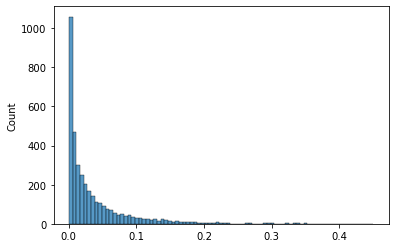

In [14]:
## 分析hitRate的数据分布，找到合适阈值

import seaborn as sns
hitRate_list=list(item_hitRate.values())
# sns.histplot([1 if i >=0.05 else 0 for i in hitRate_list])
sns.histplot(item_hitRate)